In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython import display
import os
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random as python_random
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)
print(tf.__version__)

path = 'C:\\Users\\WCW20000306\\Desktop\\Kaggle\\Chest_Xray-Pneumonia_Classification'
os.chdir(path)

2.7.0


## As the huge amount of dataset, please download it from Kaggle.
## Link: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

## Image preprocessing

In [11]:
# ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
height, width = 64, 64

def generate_data(DIR, batch_size=16):
    datagen = ImageDataGenerator(rescale=1./255.)
    
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=batch_size,
        shuffle=False,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'NORMAL': 0, 'PNEUMONIA': 1}
    )
    return generator

def generate_data_augmented(DIR):
    datagen = ImageDataGenerator(
        rescale=1./255.,
        zoom_range=0.1,
        rotation_range=0.1,
        width_shift_range=0.1,
        height_shift_range=0.1
    )
    generator = datagen.flow_from_directory(
        DIR,
        batch_size=16,
        seed=42,
        class_mode='binary',
        target_size=(height, width),
        classes={'NORMAL': 0., 'PNEUMONIA': 1.}
    )
    return generator

TRAINING_DIR = 'chest_xray/train/'
VALIDATION_DIR = 'chest_xray/val/'
TESTING_DIR = 'chest_xray/test/'

train_generator = generate_data_augmented(TRAINING_DIR)
validation_generator = generate_data(VALIDATION_DIR)
test_generator = generate_data(TESTING_DIR)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Image demonstration

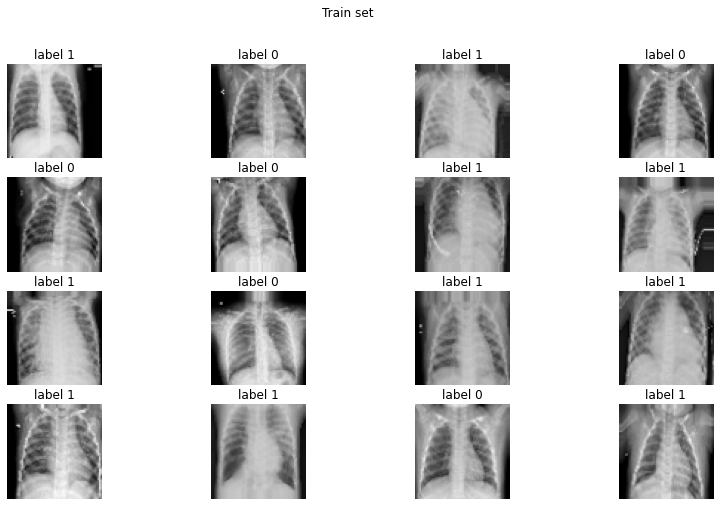

In [12]:
# view first image of each batch
# train
batch_num = math.ceil(2000/128)
col_num = 4
fig, ax = plt.subplots(int(batch_num/col_num), col_num, figsize=(14, 8))
fig.suptitle("Train set")
for k in range(batch_num):
    images, labels = train_generator.next()
    i, j = k//col_num, k%col_num
    ax[i, j].imshow(images[0])
    ax[i, j].set_title(f'label {int(labels[0])}')
    ax[i, j].axis('off')

## Building up the CNN model

In [13]:
# construct CNN model
tf.keras.backend.clear_session()
def create_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(height,width,3)),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
#        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
#         tf.keras.layers.MaxPooling2D(2,2),
#         tf.keras.layers.Dropout(0.2),
#         tf.keras.layers.Conv2D(32, (3,3), activation='relu',padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=2,strides=2),
#        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
#    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001), loss='binary_crossentropy', metrics=['acc'])
    model.compile(optimizer = tf.optimizers.Adam(), loss = 'binary_crossentropy', metrics=['acc'])
    return model

model = create_model()

## Training the CNN model

In [14]:
%%time
# train model
save_path = 'model/ts_clf_best.h5'

# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=1, min_lr=0.000001)

checkpoint = tf.keras.callbacks.ModelCheckpoint(save_path, monitor='val_loss', verbose=1, save_best_only=True)
early = tf.keras.callbacks.EarlyStopping(monitor="val_acc", mode="max", patience=6)
cb_list = [checkpoint,early]

history = model.fit(
    train_generator,
    epochs=10,
    verbose=1,
    validation_data=validation_generator,
    callbacks=cb_list
)

Epoch 1/10
 28/326 [=>............................] - ETA: 55s - loss: 0.6115 - acc: 0.7522

KeyboardInterrupt: 

## Model evaluation

In [ ]:
# plot learning curve
def plot_learning_curve(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.plot(epochs, acc, label='training acc')
    plt.plot(epochs, val_acc, label='validation acc')
    plt.legend();
    plt.figure();

    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='validation loss')
    plt.legend();

plot_learning_curve(history)

In [ ]:
model.evaluate(test_generator)

In [ ]:
import seaborn as sns

ytest = np.array([])

for batch in test_generator:
    if ytest.shape[0] == 624:
        break
    ytest = np.concatenate((ytest, batch[1]))

# get ypred 
ypred = model.predict(test_generator)
ypred = np.array([1 if x > 0.5 else 0 for x in ypred])

cf = confusion_matrix(ytest, ypred)

ax = sns.heatmap(cf, annot=True, cmap='Blues',fmt='g')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['PNEUMONIA','NORMAL'])
ax.yaxis.set_ticklabels(['PNEUMONIA','NORMAL'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
print(classification_report(ytest, ypred))
